# 树模型

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

## 线性模型的不足

线性模型的确是个好东西，理论上简单明了，具有很强的可解释性，同时实现起来也不复杂。但是，生活中能够“简单”到利用线性模型就能很好完成的任务，并不是很多。

归根结底，线性模型需要数据中有着线性关系。

- 对于回归问题，需要被解释变量和解释变量间存在线性关系，这是较为清晰明了的。
- 对于分类问题，考虑到分类问题的一般形式其实是$p = \text{softmax}(\mathbb{A} \mathbb{X})$，这就意味着分类模型还是对不同类别数据间**线性可分**有要求，一个直接的例子就是下图中的太极图，如果两类分布在阴阳鱼形状上，那么我们将很难用线性模型的形式将他们区分开。

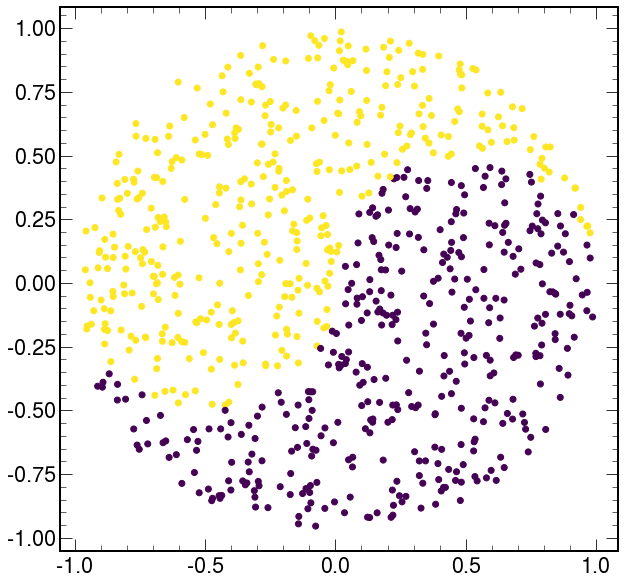

In [2]:
taichi = np.loadtxt("TextData/taichi.dat")
taichi_x = taichi[:,0]
taichi_y = taichi[:,1]
taichi_class = taichi[:,2].astype(int)
plt.scatter(taichi_x,taichi_y,c=taichi_class)

对于这样的情况，我们要怎么分开他呢？

中国古代有智慧“截弯取直”，如果我们将空间划分的更细致，是不是我们的判断就更容易一些呢？

比如，如果我们按照这样的阶梯形状画出一个分界线，那么，我们可以：
1. 判断$X$的取值在哪个区间
2. 再根据$Y$的取值判断类别

(-1.0, 1.0)

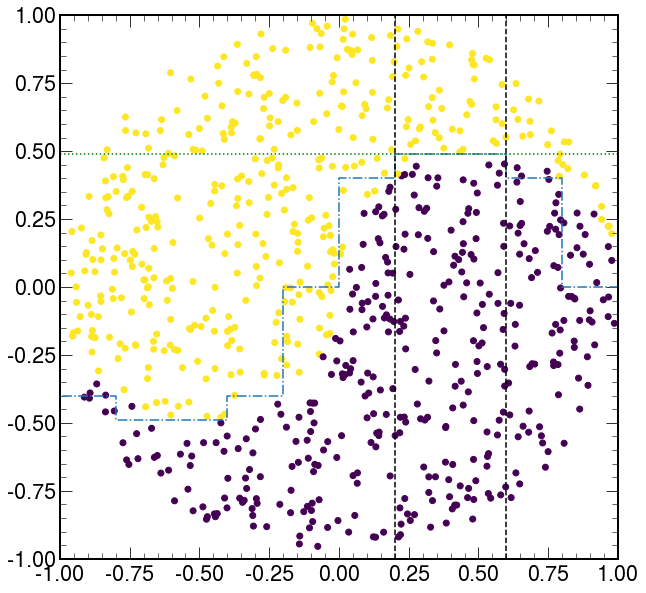

In [3]:
plt.scatter(taichi_x,taichi_y,c=taichi_class)
def y_from_x(x):
    if x > 0:
        return np.sqrt(0.5**2 - (x-0.5)**2)
    else:
        return - np.sqrt(0.5**2 - (x+0.5)**2)
x_step = np.linspace(-1,1,10+1)

y_step = [ y_from_x(i) for i in x_step]
plt.step(x_step,y_step,"-.")

plt.vlines([0.2,0.6],-1,1,linestyles="dashed",color="black")
plt.hlines(y_from_x(0.4),-1,1,linestyle="dotted",color="green")
plt.xlim(-1,1)
plt.ylim(-1,1)

我们可以将这个划分的过程看成是一个类似于二叉树的决策过程：

![TreeExample](Figures/TreeExample.drawio.svg)

事实上，这也就是决策树模型的名称由来。

虽然目前我们用树模型只是针对一个 **分类（从而目标是离散的）** 且 **自变量是连续分布的二维数组** 问题进行了 **两层** 树模型的讨论，但是推广起来也是自然的：
- 首先，即使是二维变量，我们仍然可以加深树的层数，例如判断Y的取值后，再进一步判断X的取值从而下定论
- 其次，如果自变量是离散的，我们的讨论仍然成立，只需要把连续情况的 *区间* 换成离散情况的 *类别*。 甚至更简单了！
- 再来，对于高维的变量，拓展仍然很自然 -- 我们直接添加树的层数就好了！
- 最后，到了一个比较复杂的部分：如果我们也想让树的输出是一个连续变量，这可怎么办呢？按照树的划分，似乎天然的输出就是不连续的！-- 这个问题也有一个不那么优美的解决方法：我们让树的输出，直接等于他划分出的区域里 **训练集的平均值** 。

出于教程的完整性，我可以告诉大家，对于给定的数据集，划分这样的一颗决策树，是有自动化的算法的。但无论是出于时间考虑，还是出于设计本环节的初衷，这些算法不做赘述。有兴趣的同学，可以参考scikit-learn的相关内容，或者参阅机器学习教材。
> 一般来说，决策树生成的关键是节点的分叉，节点分叉又需要有一些客观的标准。对于分类问题（离散输出），常见的两种标准是“基尼系数（Gini Index）”和信息熵（entropy）。在树的生成中，会根据当前节点的分布，依据标准自动做出划分。而对于回归问题，分叉的标准一般基于残差。

## 我们来看一个高能物理的例子吧！

在高能物理实验中，我们能够探测的是每个**事例**中的**末态粒子信息**，我们感兴趣的是这些事例中发生的物理过程。

<img src="Figures/HiggsEventDisplay.jpg" alt="Drawing" width=500/>

举例来说，希格斯粒子的发现最终为标准模型画上了浓墨重彩的一笔，但是，目前来说，希格斯粒子的性质仍然没有在实验上得到全部的确认。举例来说，希格斯粒子通过汤川耦合赋予费米子质量，但是我们对这些耦合强度还知之甚少。

另一个希格斯物理的焦点，是希格斯的自相互作用，在标准模型中，电弱对称性破缺后，拉式量中会出现希格斯粒子的自耦合项。对应到具体的物理过程，就是（在树图水平）就有三个或四个希格斯能够直接耦合。画成费曼图的话，一个典型的过程就如下图所示

<img src="Figures/DihiggsFD.jpg" alt="Drawing" width=300/>

这个过程中，两个希格斯粒子可以视为由一个希格斯粒子产生，而中间过程的希格斯粒子又来自于对撞质子中的胶子经过一个圈图产生。希格斯粒子的寿命很短（[可以参考CMS最近的测量结果](http://news.sohu.com/a/505247074_100058214)）。因此我们看到的其实是希格斯粒子的衰变后产物。希格斯粒子要衰变，最有可能的两种衰变模式，分别是衰变到一堆正反底夸克，和一堆正反W玻色子。因此，如果要探测希格斯自耦合事例，一个很有吸引力的选择便是一个希格斯粒子衰变到正反底夸克对，另一个希格斯粒子衰变到正反W玻色子对。不过不幸的是，W玻色子也得衰变。W玻色子的衰变，有强子衰变道和轻子衰变道。在我们今天的例子里，我们将会考虑轻子衰变道。W玻色子的轻子衰变将产生一个带电轻子和一个中微子，中微子无法被探测到，但是带电轻子可以，因此我们的末态粒子是一对带电轻子和一对底夸克形成的喷注

<img src="Figures/DihiggsFS.png" alt="Drawing" width=300/>

>强相互作用是一个十分神奇的相互作用，在能标较高的情况下相互作用较弱，所以我们能看到从夸克和胶子能够从高能质子束流中产生出来发生碰撞。但是在低能标下，强相互作用反而又有着所谓的禁闭效应，夸克和胶子的命运被紧紧束缚在一起，形成强子无法“挣脱”。在这两种效应的共同作用下，造就了对撞机上一种独特的物理现象：**“喷注”**。
>1. 在我们的例子里，希格斯粒子与W玻色子衰变时产生的夸克都处在高能标下，但是随着辐射效应等，能标逐渐降低而夸克与胶子数目增加，最终形成一簇强子被探测器所接收；
>2. 然而，在强子们被探测器接收后，对于实验学家来说，溯源强子的源头却难上加难，我们甚至无法判断究竟哪些喷注是来自于同一个夸克的！
>3. 鉴于此，实验上划分了一些标准，通过这些标准，实验学家对“喷注”进行只依赖于末态强子的定义，并且和理论学家的计算结果进行比对。
>> 尽管我们不会为大家展开介绍喷注的具体定义，但是大家应该能感受到一些问题：以W玻色子和希格斯粒子衰变到两个夸克为例，我们怎么能确保这两个夸克各自产生的喷注不会混合到一起呢？如果混合了，实验上我们将如何处理呢？敬请期待机器学习部分的下半场！

在我们的例子中，为了使问题简化，我们会直接给大家一套数据集，其中的事例的喷注都是来自于底夸克，轻子也都来自于W玻色子。

**不过，这并不意味着任务是掰手指头数事例数就行了。**

学习过量子力学的同学应该有着全同粒子的概念，眼下我们的末态粒子是一簇簇强子与一个个轻子，我们如何确保同样的末态一定来自于一个特定的物理过程呢？

例如，如果我们考虑这样的一个物理过程：在质子对撞中生成了一对顶夸克，顶夸克的质量极大，很不稳定，每个顶夸克有很大的概率会衰变成一个W玻色子和一个底夸克，因此，如果一对顶夸克在一个事例中被产生出来，那么这个事例将有很大的概率也有着两个底夸克和两个W玻色子的末态。**是不是和我们感兴趣的物理过程末态粒子相同？！**

<img src="Figures/TTbarFS.png" alt="Drawing" width=300/>

当然，顶夸克的对产生，和我们感兴趣的双希格斯过程，在动力学变量的分布上有着区别，这使得我们：
- 可以手动定制动力学变量的选择条件，提升信噪比，但是比较繁琐，最后难以提升
- 也可以采用机器学习方法提升信噪比

下面我们就带大家分别用线性模型和一个决策树模型（XGBoost）来应用到这个特定问题上

### 第一步：观察数据

我们首先把数据导入进来，并且看看分布长什么样吧

In [4]:
import uproot

In [5]:
import os
# Determine the base directory and the remote git path
hostname = os.uname()[1]
if 'pku.edu.cn' in hostname: # on PKU cluster
    basedir = '/data/pubfs/pku_visitor/public_write/ML/dihiggs_ntuples/'
elif 'thu' in hostname: # on THU cluster
    basedir = '/data/pubfs/pku_visitor/public_write/ML/dihiggs_ntuples/'
elif hostname.startswith('lxslc'): # on IHEP lxslc
    basedir = '/scratchfs/cms/licq/cmschina/ML/dihiggs_ntuples/'
elif hostname.startswith('lxplus'): # on CERN lxplus
    basedir = '/eos/user/c/coli/cmschina/ML/dihiggs_ntuples/'
else:
    raise RuntimeError('Machine not supported')



dihiggs = uproot.concatenate(f"{basedir}/hh2b2w.root:tree",library="pd")
ttbar = uproot.concatenate(f"{basedir}/ttbar.root:tree",library="pd")

如果我们只关注末态的轻子/喷注的动力学信息，区分度将非常有限

In [6]:
plotinfo = [ # varname, nbin, xmin, xmax
    ('bjet1_pt', 40, 0, 1000),
    ('bjet1_eta', 40, -4, 4),
    ('bjet1_phi', 40, -4, 4),
    ('bjet1_eratio', 40, 0, 15),
    ('bjet1_mass', 40, 0, 100),
    ('bjet1_ncharged', 40, 0, 40),
    ('bjet1_nneutrals', 40, 0, 40),
    ('lep1_pt', 40, 0, 1000),
    ('lep1_eta', 40, -4, 4),
    ('lep1_phi', 40, -4, 4),
    ('met', 40, 0, 600),
    ('met_phi', 40, -4, 4),
]

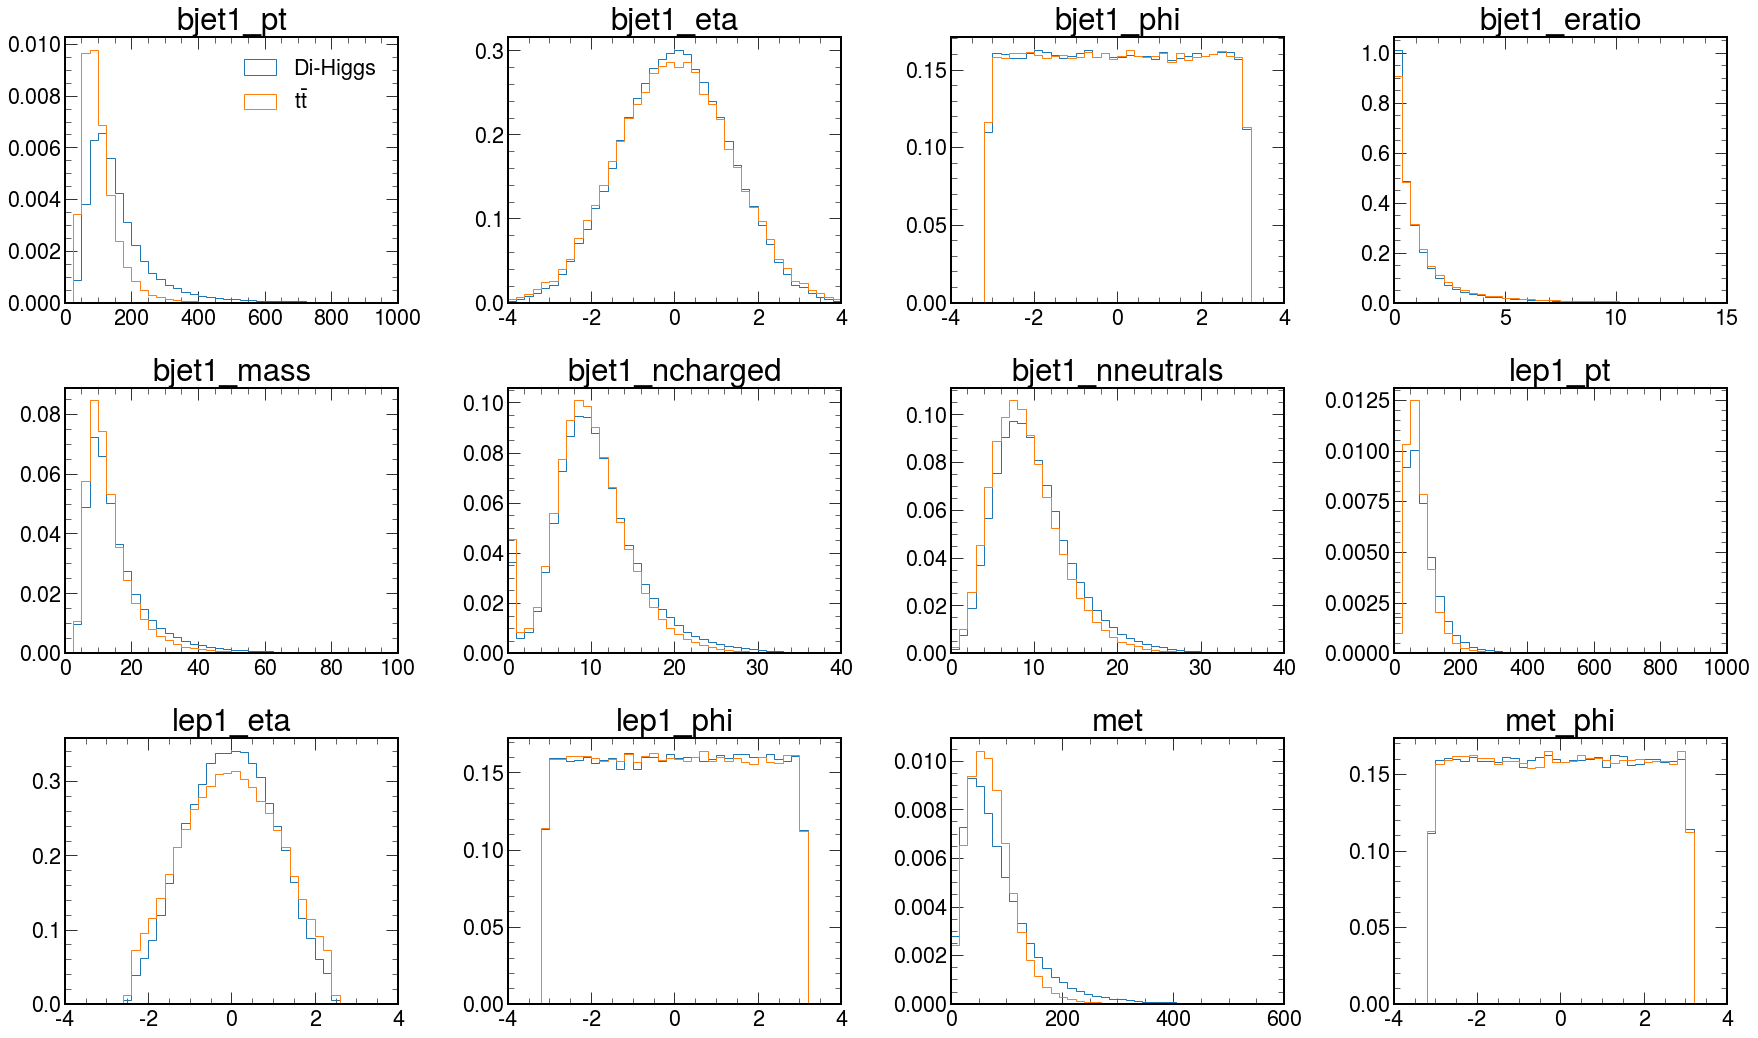

In [7]:
plt.figure(figsize=(25,15))
for i,info in enumerate(plotinfo):
    plt.subplot(3,4,i+1)
    varname = info[0]
    nbin = info[1]
    xmin = info[2]
    xmax = info[3]
    plt.hist(dihiggs[varname],histtype="step",bins=np.linspace(xmin,xmax,nbin+1),label = "Di-Higgs",density=True)
    plt.hist(ttbar[varname],histtype="step",bins=np.linspace(xmin,xmax,nbin+1),label = "$t\\bar{t}$",density=True)
    if i == 0:
        plt.legend()
    plt.xlim(xmin,xmax)
    plt.title(varname)
    plt.tight_layout()

注意到，从单个物理对象来看，区分度并不显著

但是，如果我们考虑多个物理对象之间的关联，情况是否会得到改善？

Text(0.5, 1.0, '$\\Delta\\eta_{l_1,l_2}$')

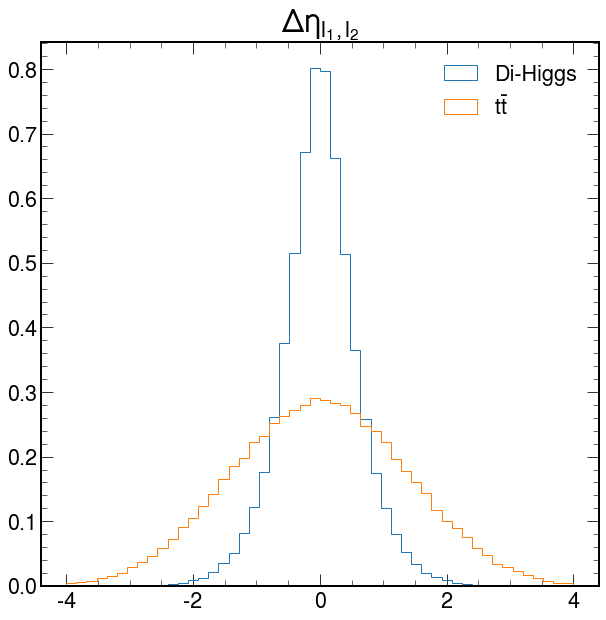

In [8]:
plt.hist(dihiggs['lep1_eta']-dihiggs['lep2_eta'],histtype="step",bins=np.linspace(-4,4,50+1),label = "Di-Higgs",density=True)
plt.hist(ttbar['lep1_eta']-ttbar['lep2_eta'],histtype="step",bins=np.linspace(-4,4,50+1),label = "$t\\bar{t}$",density=True)
plt.legend()
plt.title("$\\Delta\eta_{l_1,l_2}$")

比如，如果我们关心两个末态轻子之间的角度关联，做出上面的赝快度之差，我们就会发现：
- 对于底夸克对产生，这对底夸克将会倾向于背靠背，而因为底夸克较重，其衰变产物将倾向于与底夸克方向一致，因此衰变出的W玻色子及轻子也会更加背靠背
- 对于希格斯粒子的对产生，两个轻子将会来自于一个希格斯粒子衰变出的两个W玻色子，因为质量相差不大，希格斯粒子衰变出的两个W玻色子的背靠背效应就没有那么明显，从而轻子的背靠背效应也就更不显著 

因此，如果我们能够利用机器学习技术，同时将多个动力学变量纳入分析，就可以利用这些动力学变量之间的关联更加有效率的提取信号。

在进行机器学习之前，让我们先将数据集一分为二，一部分作为“已知”样本，用来构造我们的数据驱动的机器学习模型，另一部分作为“未知”样本，用来检验我们模型的学习成果

In [9]:
all_data = pd.concat([dihiggs,ttbar],axis=0)
all_data

,event,is_sig,is_bkg,bjet1_pt,bjet1_eta,bjet1_phi,bjet1_eratio,bjet1_mass,bjet1_ncharged,bjet1_nneutrals,...,lep1_eta,lep1_charge,lep1_type,lep2_pt,lep2_phi,lep2_eta,lep2_charge,lep2_type,met,met_phi
0,0,True,False,191.402328,-0.291164,-0.979666,0.289940,16.695002,12,6,...,-0.773752,1,0,17.508558,1.165262,-0.711694,-1,0,233.613846,2.300718
1,1,True,False,68.452507,-1.215415,2.387005,0.492361,15.253864,10,10,...,0.606327,1,1,50.567219,-1.089323,0.409210,-1,1,102.682526,-0.004101
2,2,True,False,152.725433,0.449958,-1.470235,1.215402,12.211457,12,8,...,0.174719,1,1,43.384056,0.584961,0.624317,-1,0,57.796436,0.935978
3,3,True,False,107.360390,0.124028,-1.175005,0.000000,6.060685,6,4,...,0.354157,1,1,26.664654,2.175398,0.556468,-1,1,65.674774,1.417736
4,4,True,False,97.040932,2.160315,-2.940341,0.000000,10.475123,10,14,...,1.324205,-1,1,29.825296,0.306789,0.310836,1,0,94.994255,-3.043913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149995,False,True,169.980515,-0.147777,2.985398,0.209411,27.176857,12,8,...,0.043173,-1,1,92.388741,-0.697610,0.483596,1,1,131.839859,-0.000835
149996,149996,False,True,47.205002,1.002193,-1.613720,0.000000,9.505911,10,8,...,-1.080385,-1,0,62.515564,0.693190,0.890577,1,0,75.465065,1.878048
149997,149997,False,True,63.940311,0.381228,0.494209,0.166411,8.920477,10,8,...,0.518369,1,0,34.591877,2.737549,-0.180914,-1,1,59.409447,0.176429
149998,149998,False,True,89.012772,-0.562279,-0.638000,0.648749,13.602261,11,12,...,-0.334734,-1,1,20.882822,-3.140386,-1.086141,1,0,44.600636,-1.177096


需要的数据列是：
1. 对于解释变量（自变量）：我们需要的是所有的动力学信息
2. 我们的目标是分类，所以我们需要的是两列分类信息

In [10]:
X = all_data[['bjet1_pt', 'bjet1_eta', 'bjet1_phi',
       'bjet1_eratio', 'bjet1_mass', 'bjet1_ncharged', 'bjet1_nneutrals',
       'bjet2_pt', 'bjet2_eta', 'bjet2_phi', 'bjet2_eratio', 'bjet2_mass',
       'bjet2_ncharged', 'bjet2_nneutrals', 'lep1_pt', 'lep1_phi', 'lep1_eta',
       'lep1_charge', 'lep1_type', 'lep2_pt', 'lep2_phi', 'lep2_eta',
       'lep2_charge', 'lep2_type', 'met', 'met_phi']] # 有没有更简单的写法？
y = all_data[['is_sig','is_bkg']] 

接下来，利用Sklearn提供的函数按照9:1的比例分离训练和测试集

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### 线性模型
我们首先考虑用逻辑回归来解决这个分类问题：

In [12]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,penalty="none",max_iter=1000).fit(X_train, y_train['is_sig'])
clf.score(X_test, y_test['is_sig'])

/opt/AtlasJupyterhub/miniconda3/envs/wintercamp_ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6972666666666667

In [13]:
test_score = clf.predict_proba(X_test)
test_score_sig = test_score[y_test['is_sig']][:,1]
test_score_bkg = test_score[y_test['is_bkg']][:,1]

(0.0, 1.0)

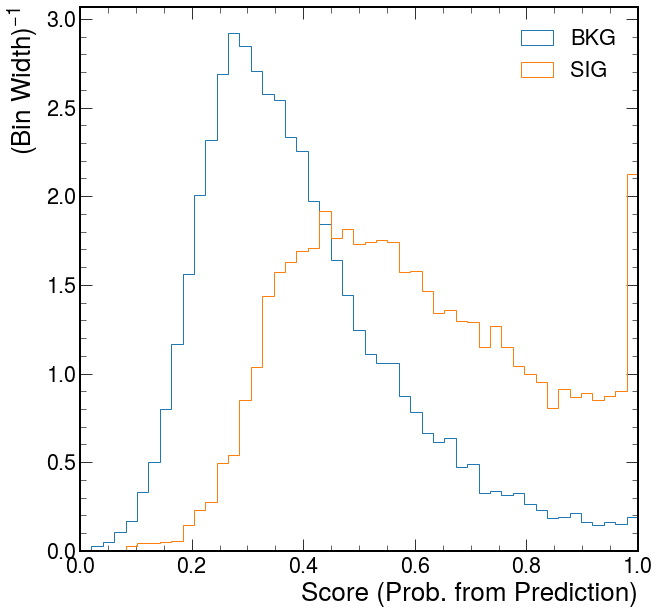

In [29]:
hist_bkg = plt.hist(test_score_bkg,label = "BKG",histtype="step",bins = np.linspace(0,1),density=True)
hist_sig = plt.hist(test_score_sig,label = "SIG",histtype="step",bins = np.linspace(0,1),density=True)
plt.xlabel("Score (Prob. from Prediction)")
plt.ylabel("(Bin Width)$^{-1}$")
plt.legend()
plt.xlim(0,1)

可以看到，逻辑回归的可以起到一定的区分作用，但是分离效果并不是很好。

如何更加坚实的评价这一结果？

#### ROC曲线

对于一个分类问题来说，最终我们往往需要为模型报告的分数设定一个阈值。按照是否通过阈值，可以将样本分为两类。那么，在分类中，就会有**信号样本被分成信号样本的概率（True Positive Rate, TPR）** 和 **背景样本被分为信号样本的概率（False Positive Rate, FPR）**。

实际的阈值选取往往面对两难的局面：阈值过低，**FPR**会升高，阈值过高，**TPR**又会降低。

因此，在评价分类模型时，往往会使用 **接收者操作特征曲线(Receiver Operating Characteristic curve，或者叫ROC曲线）** 来进行评价。这条曲线的得到方法如下：
1. 每个阈值 **Th**，都对应着一个 **TPR** 和 **FPR**
2. 将**Th**在[0,1]间变动，对应的二维数组 **（TPR,FPR）** 可以画出一条曲线，即为**ROC**曲线

In [49]:
import matplotlib.animation as animation
from IPython import display
def update_hist(ie):
    
    ax1.cla()
    ax2.cla()
    
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,3.2)
    ax2.set_yscale('log'); ax2.set_xlim(0, 1); ax2.set_ylim(1e-3, 1)
    
    edge = edges[:-1][::-1][ie]

    ax1.step(edges,[0] + [i for i in hist_bkg[0]], label = "BKG")
    ax1.step(edges,[0] + [i for i in hist_sig[0]], label = "SIG")
    
    ax1.vlines(edge,0,5,colors="grey", label = f"Cut: {edge:.2f}")
    
    
    fpr.append(hist_bkg[0][nedge - ie - 2:].sum()/hist_bkg[0].sum())
    fpr_tmp = hist_bkg[0][nedge - ie - 2:].sum()/hist_bkg[0].sum()
    tpr.append(hist_sig[0][nedge - ie - 2:].sum()/hist_sig[0].sum())
    tpr_tmp = hist_sig[0][nedge - ie - 2:].sum()/hist_sig[0].sum()
    
    ax1.bar((edges[nedge - ie-2:-1]+edges[nedge -ie-1:])/2 ,hist_bkg[0][nedge -ie-2:],width = edges[0]-edges[1],align="center",color="blue",hatch = '////',alpha=0.3,label = f"FPR:{fpr_tmp:.2f}")
    ax1.bar((edges[nedge - ie-2:-1]+edges[nedge -ie-1:])/2 ,hist_sig[0][nedge -ie-2:],width = edges[0]-edges[1],align="center",color="red",hatch='\\',alpha=0.3,label=f"TPR:{tpr_tmp:.2f}")
    ax2.plot(tpr,fpr,label = "ROC Curve")
    
    ax1.legend()
    ax2.legend(loc="lower right")
    ax1.set_xlabel("Score (Prob. from Prediction)")
    ax1.set_ylabel("(Bin Width)$^{-1}$")
    ax2.set_xlabel("TPR: HH(Sig.) Efficiency")
    ax2.set_ylabel("FPR: $t\\bar{t}$(Bkg.) Efficiency")

In [50]:

edges = hist_bkg[1]
nedge = len(edges)
fpr = []
tpr = []

fig = plt.figure(figsize = (14,7),tight_layout = True)
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)


update_hist(0)
anim = animation.FuncAnimation(fig, update_hist, frames=range(49),repeat = False)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

在Sklearn里有一些包装好的函数可以方便的画出**ROC**曲线

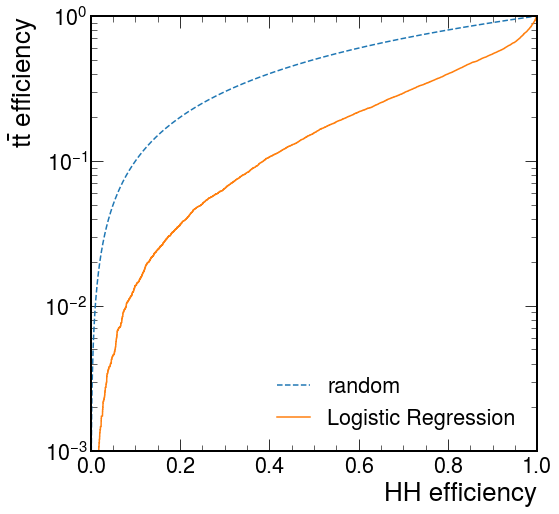

In [18]:

import sklearn.metrics as m
fpr_clf, tpr_clf, _thres = m.roc_curve(y_test['is_sig'],test_score[:,1])


f, ax = plt.subplots(figsize=(8, 8))
ax.cla()
ax.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), '--', label='random')
ax.plot(tpr_clf, fpr_clf, label='Logistic Regression')
ax.set_yscale('log'); ax.set_xlim(0, 1); ax.set_ylim(1e-3, 1)
ax.set_xlabel('HH efficiency', ha='right', x=1.0); ax.set_ylabel(r'$t\bar{t}$ efficiency', ha='right', y=1.0)
ax.legend()


其中"random"线，是考虑我们给每个样本一个[0,1]间的均等的随机概率，这样的话，无论阈值多少，我们预期的**TPR**和**FPR**将相等（例如当阈值为**0.4**时，因为分数是随机的，**TPR**=**FPR**=**(1-0.4)**=**0.6**）。

所以，从ROC曲线上来看，逻辑回归的确起到了提高信号效率的作用。表现在信号通过率**TPR**相近的情况下，逻辑回归的误判率**FPR**更小。（在随机概率的曲线下方）
> 对于背景样本来说，判断正确的概率是**True Negative Rate, TNR**，对于二分类问题，自然有**TNR = 1-FPR**，因此，另一种ROC曲线的等价画法，是画出**（TPR，TNR）** 曲线，这样的话，**ROC**曲线下方的面积 **( Area Under Curve, AUC)** 越大越好，**AUC** 也是一种常见的评价分类模型效果的指标。

对于逻辑回归的改进，包括但不限于以下几点可以尝试的内容：
- 采用正则化："L1","L2"或者"elasticnet"
- 检查各个输入变量间的关联，重新选择变量等

### 树模型

若要尽可能的从背景中挖掘出信号过程，仅仅依靠动力学变量间的线性关系是远远不够的，我们需要向前迈进一步。

下面，我们将以树模型为例给大家做一些介绍。

In [19]:
from sklearn.tree import DecisionTreeClassifier
clf1 = DecisionTreeClassifier(random_state=0).fit(X_train,y_train['is_sig'])

In [20]:
clf1.predict_proba(X_test)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

大家有没有觉得有些疑问：为什么上面的决策树输出的概率是0或1而不是我们常见的概率呢？

其实这是自洽的：如果我们使用单棵树做分类，却又允许树随意生长，那么划分就是唯一确定的！

但是这样唯一确定的划分显然不会是一个我们满意的结果：
>最大的问题是，这一种唯一确定的划分方式，其结果将必然依赖于训练集：决策树的本质是在对相空间进行细致的划分（复习考试），那么他划分的相空间是否真的是我们想要的相空间区域（学习到必要的知识），还是针对**训练集的相空间**做出的优化（熟练掌握往年题）？如果是后者，那么在应用这个模型的时候，效果将可能不尽如人意。一个典型的现象，即是在测试数据集上表现远低于训练数据集。
>
>对决策树模型的这一现象，可以用术语 **“过拟合（Over fitting）”** 加以描述。


进一步解决单棵树带来的麻烦有一个直接的方法：同时引入多棵树。

至于如何引入多棵树，方法主要有两种：
1. 一种方法是：直接引入大量的独立树，这种方法被称为随机森林，使用这种方法时，一般还伴随着数据集的增强操作，以满足大量树的训练；
2. 另一种方法是：引入迭代，同时在每一次迭代后，都计算一次残差，然后将残差作为下一棵新树回归的目标，这样经过了一系列迭代后，将所有树模型的输出求和，就可以得到输出想要值的树模型

在高能物理实验中，我们一般选用第二种方法，这种方法称为提升（Boosting）。流行的实现算法有：梯度提升决策树（Gradient Boosting Decision Tree，GBDT）和XGBoost。接下来我们将以XGBoost为例进行讲解：

In [21]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(eval_metric = "logloss").fit(X_train, y_train['is_sig'])

/opt/AtlasJupyterhub/miniconda3/envs/wintercamp_ml/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [22]:
test_score_xgb = xgbc.predict_proba(X_test)
test_score_xgb_sig = test_score_xgb[y_test['is_sig']][:,1]
test_score_xgb_bkg = test_score_xgb[y_test['is_bkg']][:,1]

(0.0, 1.0)

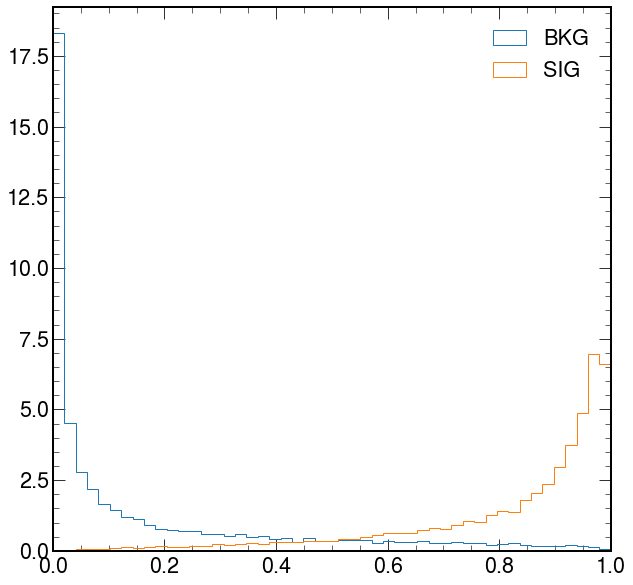

In [23]:
plt.hist(test_score_xgb_bkg,label = "BKG",histtype="step",bins = np.linspace(0,1),density=True)
plt.hist(test_score_xgb_sig,label = "SIG",histtype="step",bins = np.linspace(0,1),density=True)
plt.legend()
plt.xlim(0,1)

Wow! 即使直接使用默认设置，XGBoost也能够给出惊艳的分类效果。

下面记录一些常用的XGBoost的可调参数：

1. `learning_rate`：XGBoost是一个提升算法，对于残差，虽然XGBoost采用的策略并不是简单的基于梯度的优化，但是仍然有着类似的概念，因此，需要有一个参数控制每一步迭代的“步长”
2. XGBoost是一个树模型，因此，对于树本身的调节也是重要的：如最大深度`max_depth`，或者是分叉的节点（称为“leaf”）的个数`max_leaf_nodes` ,一般来说，这些参数越小约不容易过拟合，但也不宜过小从而树模型的表达能力不够强。
3. 此外，还有一些与残差（更一般的说法是损失函数）与训练相关的参数，可以查阅[相关文档](https://xgboost.readthedocs.io/en/stable/)

下面让我们画一画ROC曲线吧！

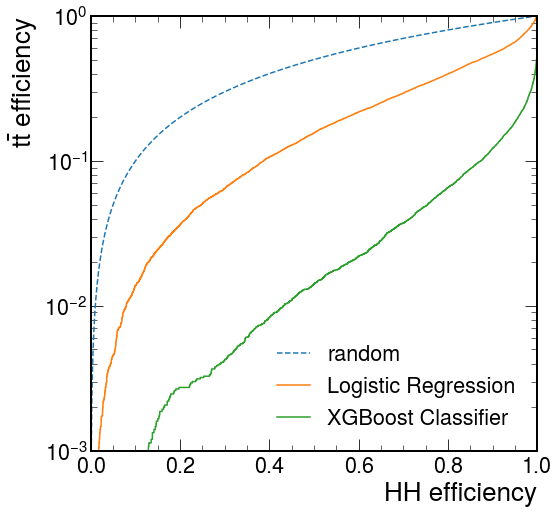

In [24]:

import sklearn.metrics as m
fpr_xgb, tpr_xgb, _thres = m.roc_curve(y_test['is_sig'],test_score_xgb[:,1])


f, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), '--', label='random')
ax.plot(tpr_clf, fpr_clf, label='Logistic Regression')
ax.plot(tpr_xgb, fpr_xgb, label='XGBoost Classifier')

ax.set_yscale('log'); ax.set_xlim(0, 1); ax.set_ylim(1e-3, 1)
ax.set_xlabel('HH efficiency', ha='right', x=1.0); ax.set_ylabel(r'$t\bar{t}$ efficiency', ha='right', y=1.0)
ax.legend()


可见，XGBoost的分类结果超出逻辑回归太多！

最后，我们来试图解读一下XGBoost做了什么：

首先，有没有什么办法查看哪些动力学变量起了重要作用？

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

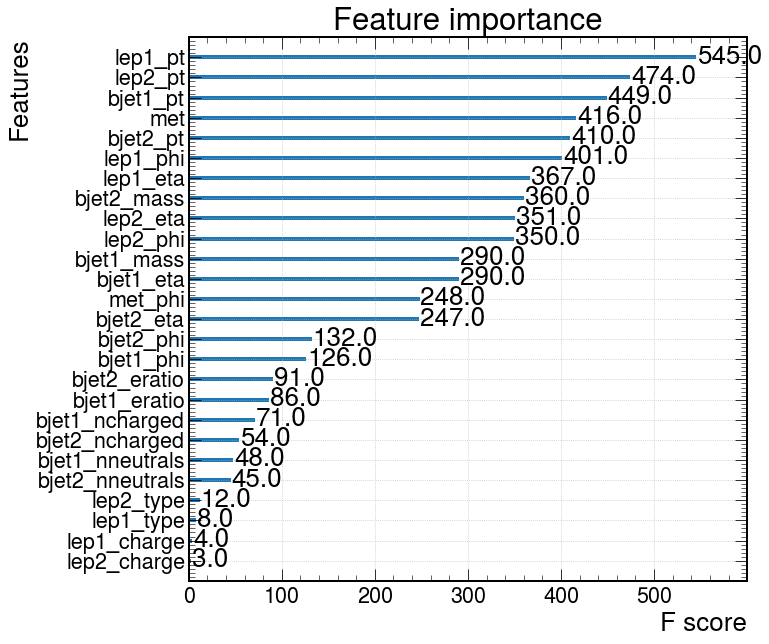

In [51]:
from xgboost import plot_importance
plot_importance(xgbc)

> F score是一种在决策树模型中常用的判断“特征”（在我们这儿对应着动力学变量）重要程度的指标，其等于这一个特征在整个分类过程中的出现次数。

进一步的，我们还可以可视化决策树的决策过程：

In [53]:
from dtreeviz.trees import dtreeviz
features = list(X_train.keys())
viz = dtreeviz(xgbc,
               x_data = X_train,
               y_data = y_train['is_sig'],
               feature_names = features,
               tree_index=1,
               orientation = "LR")
              
viz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


# 总结

下面是一点小小的总结：

1. 关于机器学习的相关概念，希望大家能够通过线性模型这样一个老熟人进行理解：线性模型麻雀虽小五脏俱全，对于机器学习概念的理解都可以从线性模型的角度出发
2. 如果大家对机器学习感兴趣的话，Sklearn是一个不可多得的宝库：不仅实现有各种机器学习算法，还有算法相关的资料。此外，Sklearn所使用的语法，已经得到了广泛接受。
3. 对于线性模型来说，基于最小二乘的回归模型是大家熟悉的，而逻辑回归虽然看上去只是简单的拓展，但是其精神被广泛地运用在一系列机器学习算法中。
> 大家不妨思考：如何对线性模型进行拓展，使其能够解决非线性问题呢？
4. 对于决策树模型，可以从两个层次上理解：单棵树完成的是基于训练数据集的相空间划分，而一般来说，需要引入多棵树来解决实际问题。
5. 在高能物理中，常见的引入多棵树的方法是提升法（boosting），一个常用的实现是XGBoost算法，相较于GBDT算法更为先进。
> 一个问题和一个拓展：问题是，如何在提升法中，给分类问题也构建残差的概念？拓展是：现在的提升算法里有没有相较于XGBoost更加先进的算法。

最后，别忘了存储下ROC曲线，方便后面一节的使用：

In [25]:
np.savetxt("TextData/roc_lr.dat",[tpr_clf,fpr_clf])
np.savetxt("TextData/roc_xgb.dat",[tpr_xgb,fpr_xgb])